In [10]:
!pip uninstall numpy matplotlib -y
!pip install numpy matplotlib

Found existing installation: numpy 1.26.3
Uninstalling numpy-1.26.3:
  Successfully uninstalled numpy-1.26.3
Found existing installation: matplotlib 3.8.2
Uninstalling matplotlib-3.8.2:
  Successfully uninstalled matplotlib-3.8.2
  Using cached numpy-1.26.3-cp310-cp310-macosx_10_9_x86_64.whl (20.6 MB)
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/Users/Pratik/Documents/GitHub/opt_for_pinns/pinns_plotting_env/lib/python3.10/site-packages/matplotlib-3.8.2.dist-info/METADATA'


[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

In [2]:
# Render plots in LaTeX
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

In [25]:
def get_best_performance(pde_name, pde_params, metric, opt, analysis_mode, extensions, entity_name):
    proj_name = f'{pde_name}_{extensions[opt]}'
    mode_name = analysis_mode['name']
    mode_values = analysis_mode['values']

    best_results = {val: np.inf for val in mode_values}

    api = wandb.Api()
    for run in api.runs(f'{entity_name}/{proj_name}'):
        if run.state != 'finished':
            continue
        config = run.config
        if config['pde_params'] != pde_params:
            continue
        
        if mode_name == 'adam_lr':
            opt_params = config['opt_params']
            mode_value = float(opt_params[opt_params.index(mode_name) + 1])
        else:
            mode_value = config.get(mode_name)
        if mode_value in best_results:
            try:
                best_results[mode_value] = \
                    np.minimum(best_results[mode_value], run.summary[metric]) \
                        if run.summary[metric] is not None else best_results[mode_value]
            except:
                print(f'Error in {run.name} in {proj_name}, run.summary[metric] = {run.summary[metric]}')

    return best_results

In [26]:
def get_best_performance_opts(pde_name, pde_params, metric, opts, analysis_mode, extensions, entity_name):
    opt_best_results = {}
    for opt in opts:
        opt_best_results[opt] = get_best_performance(pde_name, pde_params, metric, opt, analysis_mode, extensions, entity_name)
    return opt_best_results

In [27]:
def get_title(pde_name, pde_params):
    if pde_name == "convection":
        return f'Convection, $\\beta = {pde_params[1]}$'
    if pde_name == "reaction":
        return f'Reaction, $\\rho = {pde_params[1]}$'
    elif pde_name == "reaction_diffusion":
        return f'Reaction-diffusion, $\\nu = {pde_params[1]}, \\rho = {pde_params[3]}$'
    elif pde_name == "wave":
        return f'Wave, $\\beta = {pde_params[1]}$'

In [28]:
def plot_best_performance_multi_pde(pdes, metrics, opts, analysis_mode, extensions, entity_name,
                                     opt_names, metric_names, opt_colors, font_size, folder_path,
                                       filename):
    mpl.rcParams.update({'font.size': font_size})

    nrows = len(metrics)
    ncols = len(pdes)

    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))  # Adjust figsize as needed
    mode_values = analysis_mode['values']
    mode_label = analysis_mode['label']

    for row, metric in enumerate(metrics):
        for col, (pde_name, pde_params) in enumerate(pdes):
            opt_best_results = get_best_performance_opts(pde_name, pde_params, metric, opts, analysis_mode, extensions, entity_name)
            width = 0.15  # Width of the bars in the bar plot

            ax = axs[row, col] if nrows > 1 and ncols > 1 else (axs[col] if nrows == 1 else axs[row])
            for i, opt in enumerate(opts):
                ax.bar(np.arange(len(mode_values)) + i * width, [opt_best_results[opt][val] for val in mode_values],
                        width, color=opt_colors[opt], label=opt_names[opt])

            ax.set_yscale('log')
            ax.set_ylabel(metric_names[metric])
            ax.set_xlabel(mode_label)
            ax.set_xticks(np.arange(len(mode_values)) + (len(opts) - 1) * width / 2)
            ax.set_xticklabels(mode_values)
            ax.set_title(get_title(pde_name, pde_params))

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(opts))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    filename = filename + '_' + analysis_mode['name'] + '.pdf'
    fig.savefig(os.path.join(folder_path, filename), bbox_inches='tight')
    plt.show()

In [29]:
entity_name = 'sketchy-opts'
extensions = {
    'adam': 'adam_final',
    'lbfgs': 'lbfgs_final',
    'adam_lbfgs': 'adam_lbfgs_final',
    'adam_lbfgs_11k': 'adam_lbfgs_final_11k',
    'adam_lbfgs_31k': 'adam_lbfgs_final_31k'
}
opt_names = {
    'adam': 'Adam',
    'lbfgs': 'L-BFGS',
    'adam_lbfgs': 'Adam + L-BFGS (1k)',
    'adam_lbfgs_11k': 'Adam + L-BFGS (11k)',
    'adam_lbfgs_31k': 'Adam + L-BFGS (31k)'
}
opt_colors = {
    'adam': 'tab:blue',
    'lbfgs': 'tab:orange',
    'adam_lbfgs': 'tab:green',
    'adam_lbfgs_11k': 'tab:red',
    'adam_lbfgs_31k': 'tab:purple'
}
metric_names = {
    'train/l2re': 'Training L2RE',
    'train/l1re': 'Training L1RE',
    'test/l2re': 'Test L2RE',
    'test/l1re': 'Test L1RE',
    'loss': 'Loss'
}

Error in misty-music-350 in wave_adam_lbfgs_final, run.summary[metric] = NaN


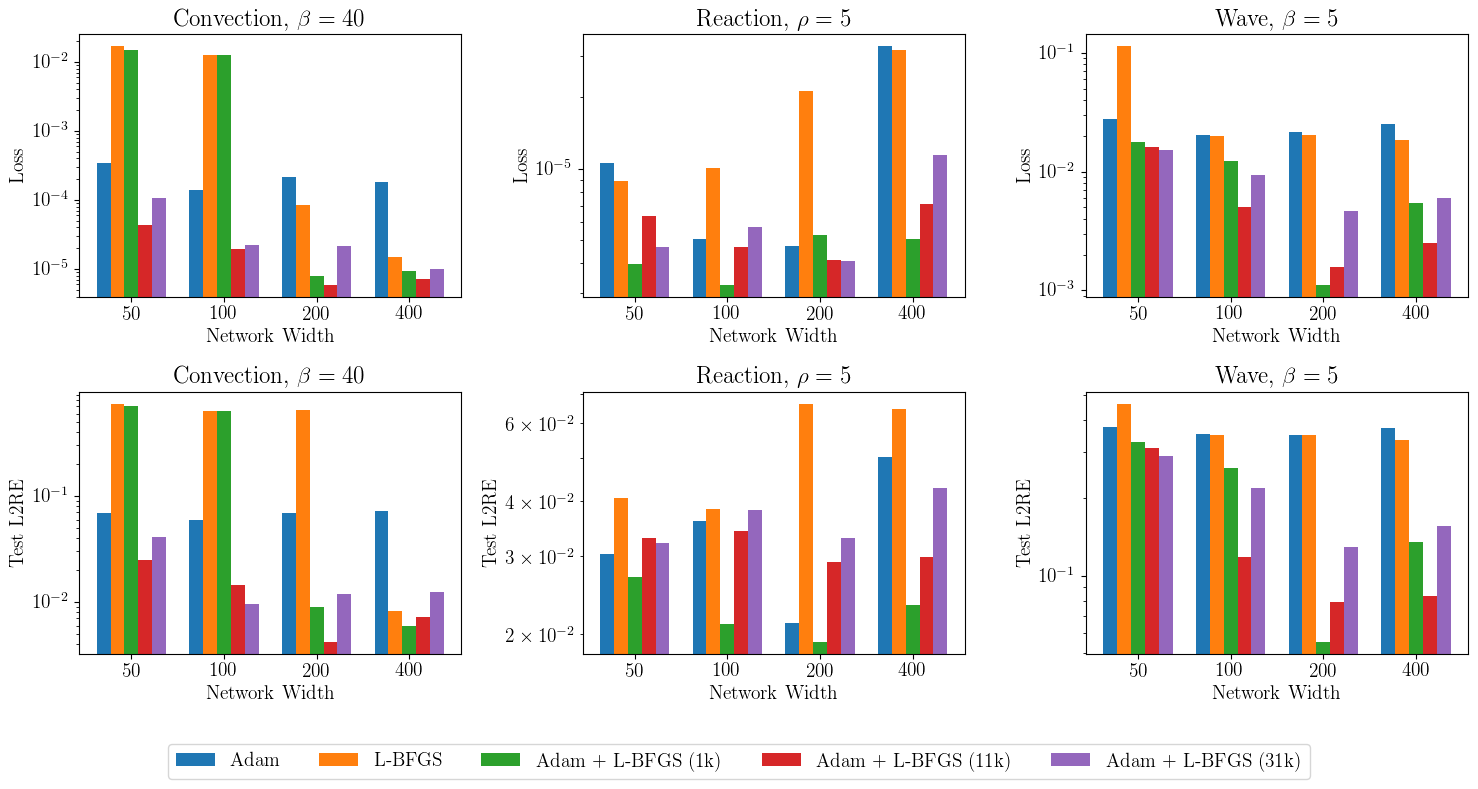

In [31]:
pdes = [('convection', ['beta', '40']), ('reaction', ['rho', '5']), ('wave', ['beta', '5'])]
metrics = ['loss', 'test/l2re']
opts = ['adam', 'lbfgs', 'adam_lbfgs', 'adam_lbfgs_11k', 'adam_lbfgs_31k']
analysis_mode_width = {
    'name': 'num_neurons',
    'values': [50, 100, 200, 400],
    'label': 'Network Width'
}
# opts = ['adam_lbfgs', 'adam_lbfgs_11k', 'adam_lbfgs_31k']
# analysis_mode_adam_lr = {
#     'name': 'adam_lr',
#     'values': [0.00001, 0.0001, 0.001, 0.01, 0.1],
#     'label': 'Learning Rate'
# }

folder_path = 'opt_comparison_plots'
filename = 'loss_l2re'

plot_best_performance_multi_pde(pdes, metrics, opts, analysis_mode_width, extensions, entity_name, opt_names, metric_names, opt_colors,
                                font_size=14, folder_path=folder_path, filename=filename)